# [Lightkurve](https://docs.lightkurve.org/)

## Table of Contents
- [Overview](#overview)
- [A Quick Introduction](#a-quick-introduction)

# Overview
Lightkurve is a user-friendly Python package that is designed to make interacting with TESS and Kepler time-series photometry easy and accessible. It is well documented, and there are pre-existing [tutorials](https://docs.lightkurve.org/tutorials/index.html) that can covers most functionality. This lesson will go over the primary use-cases, best practices, and examples, as well as some exercises to practice and improve understanding. 

# A Quick Introduction
There are three primary objects used in `Lighkurve`:
* `LightCurve` object
* `TargetPixelFile` objects
* `Periodogram` objects

This first section will give a quickstart by accessing, downloading, and plotting an exoplanet transit. 

First, we import `lightkurve`:

In [38]:
import lightkurve as lc

The first step is to download the `target pixel file`, which are the 2D images used to construct the timeseries photometry. Let's investigate the known exoplanet system **WASP-121**:

In [39]:
## Downloads all pixel files for the target
pixelfile = lc.search_targetpixelfile("WASP-121").download_all()

Let's check out the first image.

<class 'lightkurve.targetpixelfile.TessTargetPixelFile'>


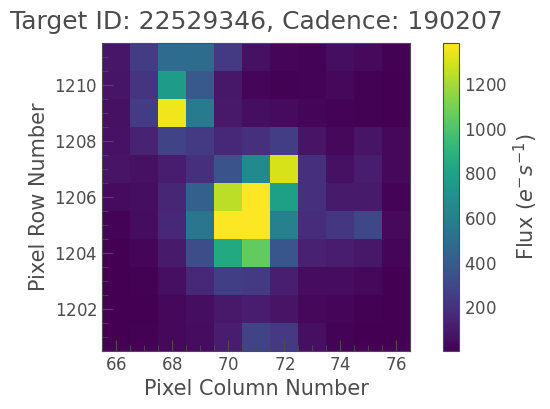

In [51]:
##Check out different images by changing the index!
pixelfile[0].plot()

##We can check the type to see which mission it's derived from (TESS or Kepler)
print(type(pixelfile[0]))

To see the light curve from this data, we use `pixelfile.to_lightcurve`:

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

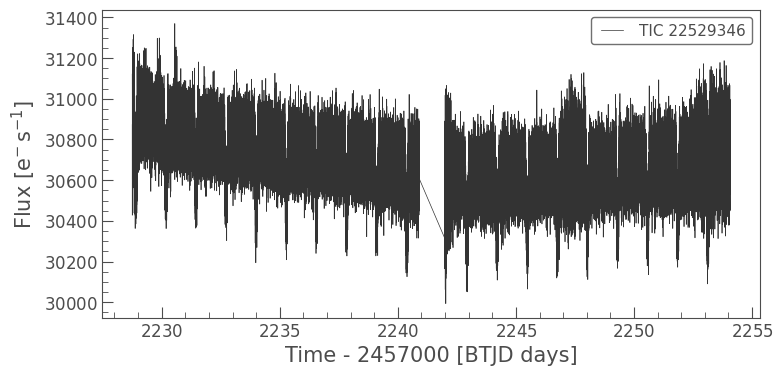

In [52]:
##Select a target pixel to analyze, which contains one sector of timeseries data
lc = pixelfile[3].to_lightcurve(aperture_mask='all')

##Plot the results!
lc.plot()

We can see repeated, deep transit signal here, but what if we want a better view? We can easily access different parts of the light curve by normal Python splicing:

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

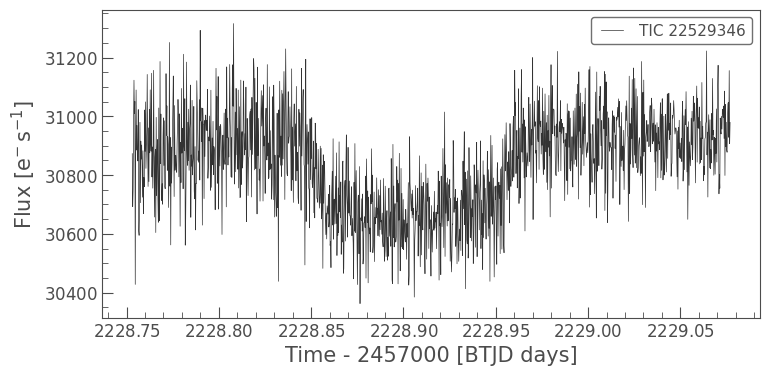

In [50]:
lc[0:1400].plot()

Congrats, you found `WASP-121 b` in real TESS data! The next sections will go more in-depth into the different functions of the three objects in the `lightcurve` module, and will finish with standard work flows that accomplish specific tasks i.e. light-curve detrending.